<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/The%20Market's%20Not%20Normal/The_Autocorrelation_of_Variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Autocorrelation of Variance
## Introduction


## Import the Standard Libary
I put everything I use "most of the time" into a python file called `my_library.py` which you must import into the workspace of this notebook to make the analysis execute. The file is available here: [`my_library.py`](https://github.com/Farmhouse121/Financial-Data-Science-in-Python/blob/main/The%20Market's%20Not%20Normal/my_library.py).

In [1]:
from my_library import *

18:53:48 Starting...
18:53:48 Installing yfinance into Google notebook...
18:54:07 Installing arch into Google notebook...
18:54:25 Initialized.


## Read the Data from _Yahoo! Finance_
I'm going to use _Yahoo! Finance_ as a data source as it is publicly available and easy to access via the `yfinance` package. You could substitute other vendors, if you have access to them.

In [2]:
df,name=download(ticker:='^GSPC',begin:='1928-01-27',end:=today('%Y-%m-%d')).dropna(),'S&P 500 Index'
df['Daily Return']=df['Adj Close'].pct_change()*hundred
df['Intraday Return']=df['Close']/df['Open']*hundred-hundred
df['Overnight Return']=(hundred+df["Daily Return"])/(hundred+df["Intraday Return"])*hundred-hundred
df.index=pd.DatetimeIndex(df.index).to_period('B')
df.dropna(inplace=True)
df.loc[df["Volume"]==0,"Volume"]=np.nan
nprint("\nDownloaded data for %s." % name)
display(df)

[*********************100%%**********************]  1 of 1 completed

18:54:27 
Downloaded data for S&P 500 Index.


,Open,High,Low,Close,Adj Close,Volume,Daily Return,Intraday Return,Overnight Return
Date,,,,,,,,,
1928-01-30,17.490000,17.490000,17.490000,17.490000,17.490000,NaN,-1.130587,0.000000,-1.130587
1928-01-31,17.570000,17.570000,17.570000,17.570000,17.570000,NaN,0.457404,0.000000,0.457404
1928-02-01,17.530001,17.530001,17.530001,17.530001,17.530001,NaN,-0.227655,0.000000,-0.227655
1928-02-02,17.629999,17.629999,17.629999,17.629999,17.629999,NaN,0.570442,0.000000,0.570442
1928-02-03,17.400000,17.400000,17.400000,17.400000,17.400000,NaN,-1.304592,0.000000,-1.304592
...,...,...,...,...,...,...,...,...,...
2024-06-13,5441.930176,5441.930176,5402.509766,5433.740234,5433.740234,3.530380e+09,0.234466,-0.150497,0.385543
2024-06-14,5424.080078,5432.390137,5403.750000,5431.600098,5431.600098,3.438650e+09,-0.039386,0.138641,-0.177781
2024-06-17,5431.109863,5488.500000,5420.399902,5473.229980,5473.229980,3.447840e+09,0.766439,0.775534,-0.009026


19:16:08 Computing ACF of squared returns...
19:16:08                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     1404.
Date:                Fri, 21 Jun 2024   Prob (F-statistic):          1.46e-147
Time:                        19:16:08   Log-Likelihood:                 115.86
No. Observations:                 504   AIC:                            -227.7
Df Residuals:                     502   BIC:                            -219.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

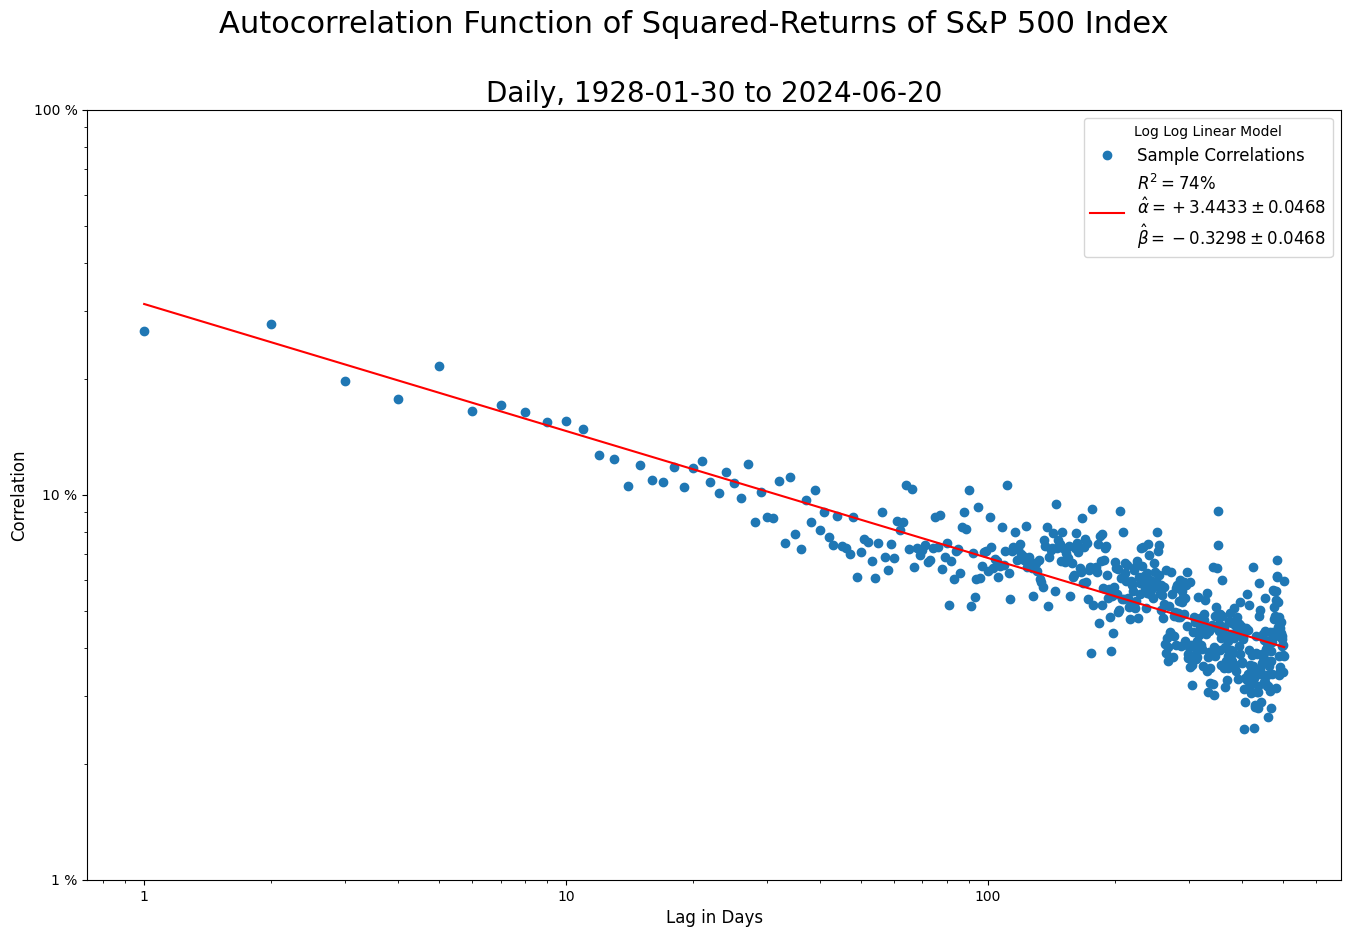

In [34]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS

nprint("Computing ACF of squared returns...")
df['r2']=df['Daily Return']**2
df['ar']=df['Daily Return'].abs()
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=np.linspace(1,nlag:=int(annualize*two),nlag),y:=acf(df['r2'],nlags=nlag)[1:]*hundred,'o',label='Sample Correlations')
model=OLS(np.log(y),add_constant(np.log(x))).fit()
nprint(model.summary())
plot.plot(x,np.exp(model.predict()),'-r',label='$R^2 = %.0f \\%%$\n$\\hat{\\alpha} = %+6.4f \\pm %.4f$\n$\\hat{\\beta}= %+6.4f \\pm %.4f$' % \
  (model.rsquared*hundred,model.params[0],model.bse[0],model.params[1],model.bse[0]))
plot.set_xscale('log')
plot.set_yscale('log')
plot.xaxis.set_major_formatter(CountLabels(0))
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.set_ylim(one,hundred)
plot.set_xlabel("Lag in Days",fontsize=12)
plot.set_ylabel("Correlation",fontsize=12)
figure.suptitle(title:="Autocorrelation Function of Squared-Returns of S&P 500 Index",fontsize=22)
plot.set_title(subtitle:="Daily, %s to %s" % (df.index[0],df.index[-1]),fontsize=20)
plot.legend(fontsize=12,title='Log Log Linear Model')
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

19:17:53 Computing PACF of squared returns...


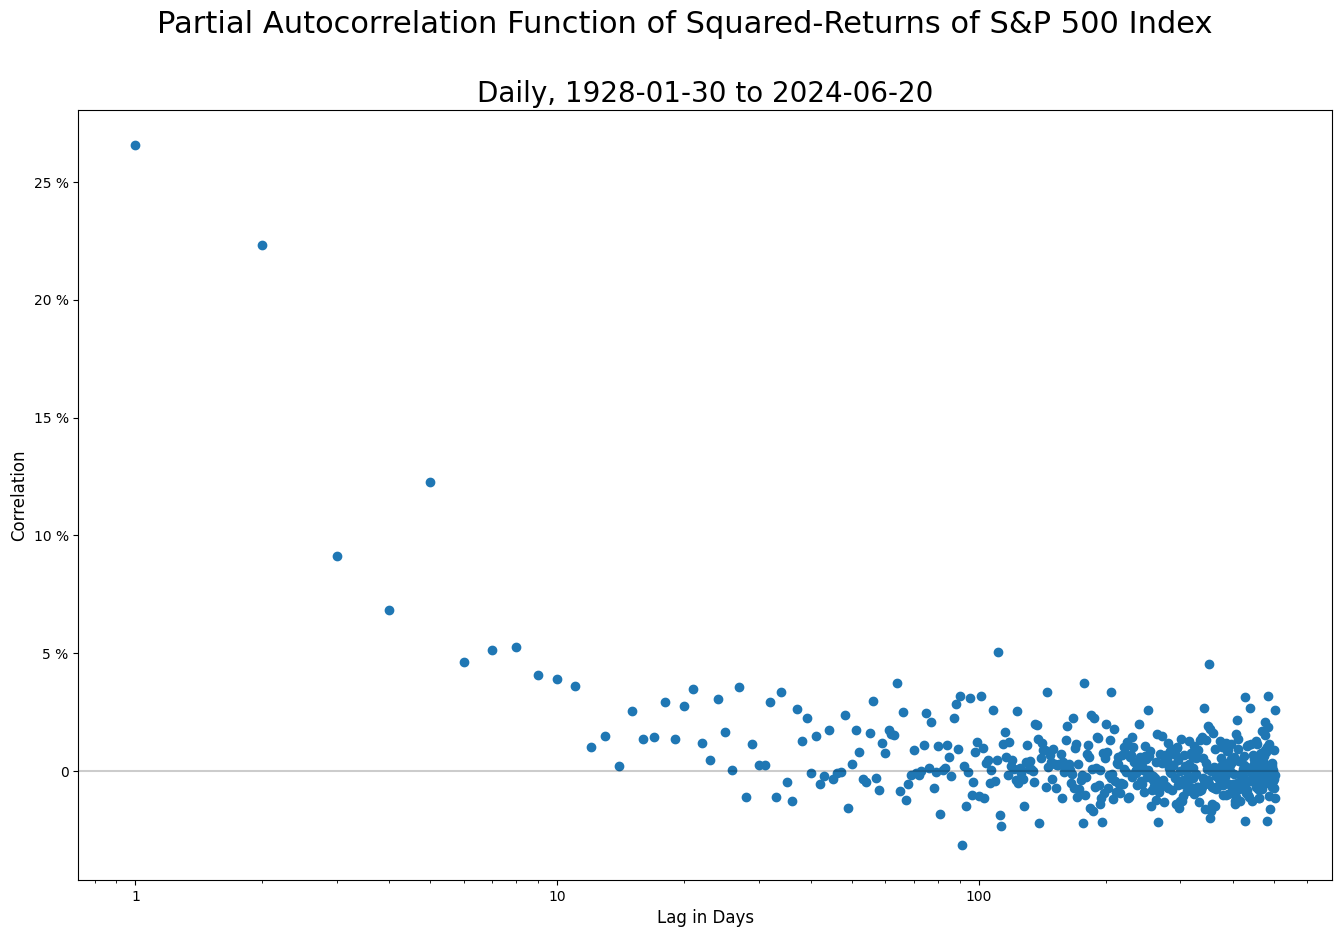

In [36]:
nprint("Computing PACF of squared returns...")
df['r2']=df['Daily Return']**2
df['ar']=df['Daily Return'].abs()
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=np.linspace(1,nlag:=int(annualize*two),nlag),y:=pacf(df['r2'],nlags=nlag)[1:]*hundred,'o')
#plot.set_xlim(,nlag+1)
plot.set_xscale('log')
plot.xaxis.set_major_formatter(CountLabels(0))
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.set_xlabel("Lag in Days",fontsize=12)
plot.set_ylabel("Correlation",fontsize=12)
plot.axhline(color='black',alpha=0.2)
figure.suptitle(title:="Partial Autocorrelation Function of Squared-Returns of S&P 500 Index",fontsize=22)
plot.set_title(subtitle:="Daily, %s to %s" % (df.index[0],df.index[-1]),fontsize=20)
#plot.legend(fontsize=12,title='Log Linear Model')
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

20:10:37 Computing Directional Autocorrelation Function


Lagged                      Negatives                      Positives  \
    Correlation     Error   Sample Correlation     Error   Sample Correlation   
Lag                                                                             
1     26.569655  0.642696  24212.0   32.986741  0.944125  11221.0   18.199441   
2     27.813460  0.642709  24211.0   30.054704  0.944125  11221.0   25.665865   
3     19.722887  0.642723  24210.0   19.816886  0.944125  11221.0   20.013493   
4     17.769631  0.642736  24209.0   23.732127  0.944167  11220.0   12.598660   
5     21.631789  0.642749  24208.0   23.560214  0.944167  11220.0   19.553727   
..          ...       ...      ...         ...       ...      ...         ...   
500    4.036954  0.649424  23713.0    4.125498  0.954432  10980.0    3.899837   
501    4.286178  0.649437  23712.0    2.627823  0.954432  10980.0    6.581321   
502    3.653528  0.649451  23711.0    3.983631  0.954475  10979.0    3.399175   
503    6.268083  0.649465  23710.0    7.712768  0.954475  10979.0    4.827242   
504    4.013132  0.649478  23709.0    3.403618  0.954475  10979.0    4.935473   

                        
        Error   Sample  
Lag                     
1    0.888208  12678.0  
2    0.888243  12677.0  
3    0.888278  12676.0  
4    0.888278  12676.0  
5    0.888313  12675.0  
..        ...      ...  
500  0.897387  12420.0  
501  0.897424  12419.0  
502  0.897424  12419.0  
503  0.897460  12418.0  
504  0.897496  12417.0  

[504 rows x 9 columns]

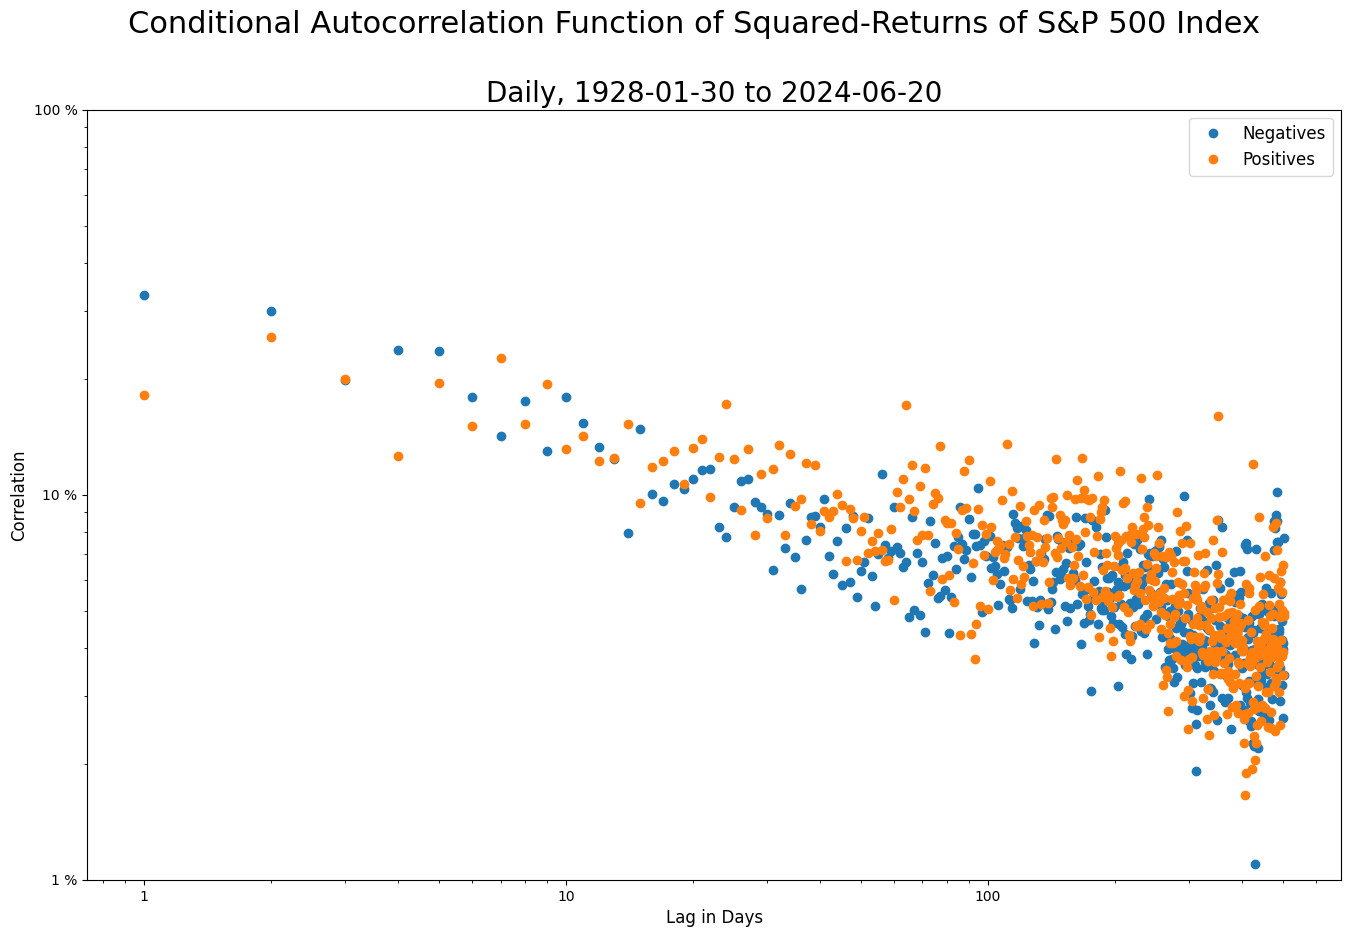

In [94]:
nprint("Computing Directional Autocorrelation Function")
df["nr2"]=df["Daily Return"].apply(lambda x:x**2 if x<zero else np.nan)
df["pr2"]=df["Daily Return"].apply(lambda x:x**2 if x>zero else np.nan)
results=pd.DataFrame({"Lag":list(map(int,x))}).set_index("Lag")

for lag in result.index:
    sample=df[["Daily Return","r2","nr2","pr2"]].copy()
    sample["Lagged"]=sample["r2"].shift(lag)
    sample["Negatives"]=sample["nr2"].shift(lag)
    sample["Positives"]=sample["pr2"].shift(lag)

    for prior in "Lagged","Negatives","Positives":
        results.loc[lag,prior+" Correlation"]=sample[["r2",prior]].corr().iloc[0,1]*hundred
        results.loc[lag,prior+" Sample"]=sample[["r2",prior]].dropna().shape[0]

results.columns=pd.MultiIndex.from_tuples(list(map(lambda x:x.split(" "),results.columns)))

for column in set(results.columns.get_level_values(0)):
    results[(column,"Error")]=np.tanh(one/np.sqrt(results[(column,"Sample")]-three))*hundred

results=results[sorted(results)]
display(results)
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))

for column in "Negatives","Positives":
    plot.plot(results.index,results[(column,"Correlation")],'o',label=column)

plot.set_xscale('log')
plot.set_yscale('log')
plot.xaxis.set_major_formatter(CountLabels(0))
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.set_ylim(one,hundred)
plot.set_xlabel("Lag in Days",fontsize=12)
plot.set_ylabel("Correlation",fontsize=12)
figure.suptitle(title:="Conditional Autocorrelation Function of Squared-Returns of S&P 500 Index",fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.legend(fontsize=12)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')


In [88]:

results

Lagged           Negatives           Positives         
                 Sample              Sample              Sample
Lag                                                            
1    26.569655  24212.0  32.986741  11221.0  18.199441  12678.0
2    27.813460  24211.0  30.054704  11221.0  25.665865  12677.0
3    19.722887  24210.0  19.816886  11221.0  20.013493  12676.0
4    17.769631  24209.0  23.732127  11220.0  12.598660  12676.0
5    21.631789  24208.0  23.560214  11220.0  19.553727  12675.0
..         ...      ...        ...      ...        ...      ...
500   4.036954  23713.0   4.125498  10980.0   3.899837  12420.0
501   4.286178  23712.0   2.627823  10980.0   6.581321  12419.0
502   3.653528  23711.0   3.983631  10979.0   3.399175  12419.0
503   6.268083  23710.0   7.712768  10979.0   4.827242  12418.0
504   4.013132  23709.0   3.403618  10979.0   4.935473  12417.0

[504 rows x 6 columns]